<a href="https://colab.research.google.com/github/tanvir-talha058/Machine-Learning/blob/main/banglabert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers datasets pandas scikit-learn


In [2]:
pip install -U transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [3]:
pip install --upgrade transformers


In [25]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding, set_seed
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Set random seed
set_seed(42)

# Step 1: Load CSV
df = pd.read_csv("dataset.csv", encoding='utf-8')  # Save your Excel as CSV first

# Step 2: Reshape Data
rows = []
for col in df.columns:
    for val in df[col].dropna():
        rows.append({'text': val.strip(), 'label': col})

data = pd.DataFrame(rows)

# Step 3: Label Encoding
label2id = {label: i for i, label in enumerate(data['label'].unique())}
id2label = {i: label for label, i in label2id.items()}
data['label_id'] = data['label'].map(label2id)

# Step 4: Train-test split
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label_id'], random_state=42)

# Step 5: Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label_id']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label_id']])

# Step 6: Load BanglaBERT Tokenizer
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True) # Removed padding=True

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Rename 'label_id' to 'labels' in the datasets BEFORE initializing Trainer
train_dataset = train_dataset.rename_column("label_id", "labels")
test_dataset = test_dataset.rename_column("label_id", "labels")

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])


# Step 7: Load Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id))

# Step 8: Metrics
def compute_metrics(pred):
    print("Pred object:", pred) # Add print statement
    print("Pred label_ids:", pred.label_ids) # Add print statement
    if pred.label_ids is None:
        return {} # Return empty dict if labels are None
    labels = pred.label_ids.astype(int)
    preds = np.argmax(pred.predictions, axis=1).astype(int)

    print("Labels unique values:", np.unique(labels)) # Add print statement
    print("Preds unique values:", np.unique(preds)) # Add print statement
    print("Labels dtype:", labels.dtype) # Add print statement
    print("Preds dtype:", preds.dtype) # Add print statement


    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro', zero_division=0)
    }

# Step 9: Training Config
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    save_strategy="epoch",
    # label_names=["labels"] # Removed this as it's not a valid argument
)

# Step 10: Train
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


# Add a print statement to inspect the dataset keys before training
print("Train dataset features:", train_dataset.features)
print("Test dataset features:", test_dataset.features)


trainer.train()

# Optional: Save Model
model.save_pretrained("banglabert-dialect-classifier2")
tokenizer.save_pretrained("banglabert-dialect-classifier2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1412 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/353 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4136441433.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Train dataset features: {'labels': Value('int64'), '__index_level_0__': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}
Test dataset features: {'labels': Value('int64'), '__index_level_0__': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tanvirbhai-unofficial (tanvirbhai-unofficial-my-self-defense) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.216801,0.487252,0.476693
2,No log,1.081259,0.572238,0.574246
3,0.985000,1.190683,0.586402,0.590659
4,0.985000,1.276401,0.611898,0.615883
5,0.985000,1.479283,0.577904,0.575272
6,0.419800,1.548123,0.589235,0.594041
7,0.419800,1.737350,0.583569,0.586849
8,0.419800,1.809269,0.600567,0.603954
9,0.331900,1.916516,0.586402,0.589376
10,0.331900,1.899297,0.583569,0.588148


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a596a87bc50>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59889febd0>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988aa5990>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988a738d0>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988a12b50>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988a5a8d0>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59888f3c90>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59889031d0>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59889d20d0>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988a9f790>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59889cc2d0>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988803d90>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a598892b050>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988927350>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988832710>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a598897ce90>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988929250>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59889357d0>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59889a7790>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a5988802c10>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


('banglabert-dialect-classifier2/tokenizer_config.json',
 'banglabert-dialect-classifier2/special_tokens_map.json',
 'banglabert-dialect-classifier2/vocab.txt',
 'banglabert-dialect-classifier2/added_tokens.json',
 'banglabert-dialect-classifier2/tokenizer.json')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Pred object: <transformers.trainer_utils.EvalPrediction object at 0x7a59889d3790>
Pred label_ids: [1 3 0 4 3 4 3 3 4 3 3 2 3 3 2 3 2 3 2 1 2 1 1 4 4 3 0 0 4 0 4 2 2 4 1 1 1
 4 4 1 1 3 2 2 0 4 0 2 2 2 4 0 4 1 1 0 3 1 2 3 3 1 4 0 4 0 0 4 2 2 2 4 1 1
 0 4 3 3 2 0 0 4 0 0 0 1 3 1 0 0 4 1 2 1 1 0 3 3 4 3 4 0 1 4 2 2 2 0 2 2 0
 4 4 3 1 1 1 3 0 1 4 0 3 3 3 0 4 2 2 2 3 1 4 3 1 4 2 3 1 0 3 2 3 3 1 4 1 0
 1 3 2 1 2 0 0 0 0 3 2 2 1 3 0 0 2 4 1 3 4 3 2 3 4 0 4 0 3 3 0 2 1 4 4 0 2
 2 2 1 3 3 0 2 1 1 3 1 1 0 0 4 3 1 3 3 3 1 0 1 2 3 1 0 1 3 2 1 4 2 0 0 0 1
 2 4 4 3 1 0 3 4 0 3 1 1 0 1 1 4 0 3 4 3 2 4 4 1 0 0 0 4 3 3 2 4 3 4 4 2 0
 3 0 4 0 2 1 2 0 1 4 2 2 0 2 0 2 0 4 2 1 4 2 0 1 0 0 4 2 2 2 4 2 0 1 1 1 4
 1 3 4 4 3 3 4 0 0 3 4 3 3 1 4 4 2 1 0 1 2 4 3 0 0 2 1 0 2 3 4 2 1 4 3 0 2
 3 4 3 1 1 3 2 1 1 2 4 2 4 4 2 2 3 2 4 2]
Labels unique values: [0 1 2 3 4]
Preds unique values: [0 1 2 3 4]
Labels dtype: int64
Preds dtype: int64


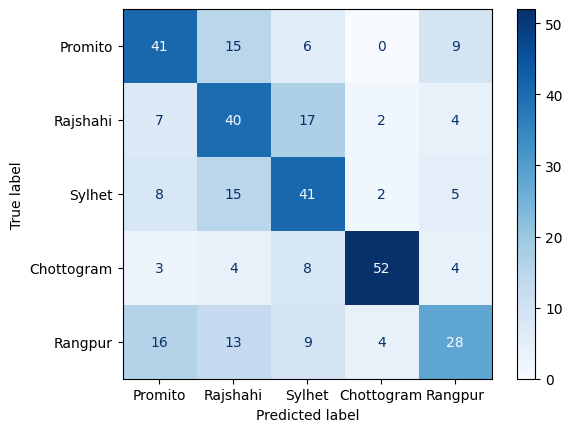

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np # Import numpy

y_true = trainer.eval_dataset["labels"] # Changed from "label_id" to "labels"
y_pred = np.argmax(trainer.predict(trainer.eval_dataset).predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2id.keys())
disp.plot(cmap="Blues")

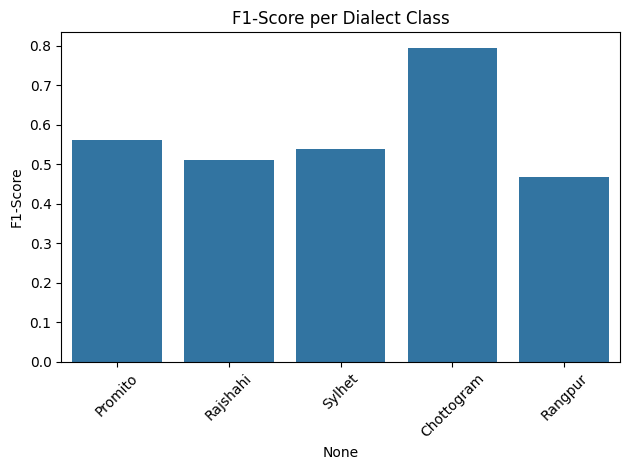

In [27]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(y_true, y_pred, target_names=label2id.keys(), output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.barplot(x=df_report.index[:-3], y=df_report["f1-score"][:-3])
plt.title("F1-Score per Dialect Class")
plt.ylabel("F1-Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


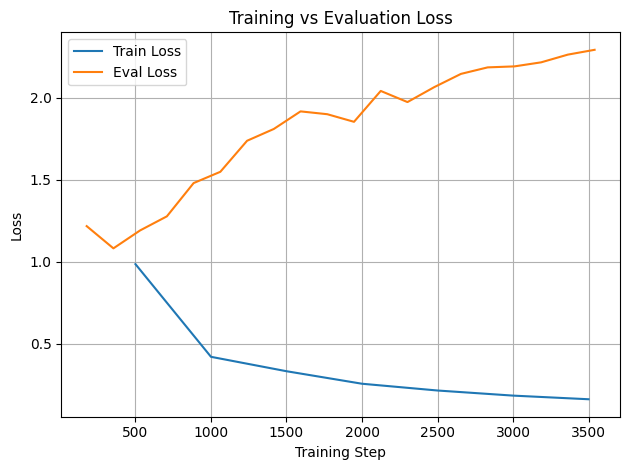

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)

train_loss = df_logs[df_logs["loss"].notnull()][["step", "loss"]]
eval_loss = df_logs[df_logs["eval_loss"].notnull()][["step", "eval_loss"]]

plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Eval Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
